In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

In [4]:
from craco.preprocess import fast_preprpocess

In [5]:
from craft import uvfits, craco_plan
from craco import uvfits_meta, calibration

In [5]:
fname = "/data/craco/gup037/DATA/SB057841/DATA/DATA_01/craco/SB057841/scans/00/20240121205332/b00.uvfits"
meta_name = "/data/craco/gup037/DATA/SB057841/SB057841/SB57841.json.gz"
calname = "/data/craco/gup037/DATA/SB057841/SB057841/cal/00/b00.aver.4pol.smooth.npy"

In [123]:
values = craco_plan.get_parser().parse_args(["--flag-ants", "12,15,20,30", "--calibration", calname])

In [124]:
f = uvfits_meta.open(fname, metadata_file = meta_name)
f.set_flagants(values.flag_ants)
block0, uvws0 = next(f.fast_time_blocks(nt = 256))
block0.shape

(325, 1, 1, 1, 288, 1, 256)

In [125]:
plan = craco_plan.PipelinePlan(f, values)
calsoln = calibration.CalibrationSolution(plan)

/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=258.0 1-2 uvpix=(1, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=258.0 1-2 uvpix=(2, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=515.0 2-3 uvpix=(0, 255)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=526.0 2-14 uvpix=(0, 19)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=526.0 2-14 uvpix=(0, 20

In [126]:
input_block = block0.squeeze()[:, :, :block0.shape[-1]//1]
input_data = input_block.data
input_mask = input_block.mask

nbl, nf, nt = input_block.shape
isubblock = 0
output_buf = np.zeros_like(input_data)
#output_mask = np.zeros_like(input_mask)

Ai = np.zeros((nbl, nf), dtype=np.complex64)
Qi = np.zeros((nbl, nf), dtype=np.complex64)
N = np.ones((nbl, nf), dtype=np.int16)

cas = np.zeros((nf, nt), dtype=np.float64)
crs = np.zeros((nf, nt), dtype=np.float64)
cas_N = np.zeros((nf, nt), dtype=np.int16)

cal= calsoln.solarray.mean(axis=2).squeeze()
calsoln_data = cal.data
calsoln_mask = cal.mask

target_input_rms = None


In [127]:
#Computing cas and crs add 150ms of processing time per block (256 samples).
#Computing just the crs(aka pcb) adds 50ms
#Computing crs and cas adds 70ms (so 20ms extra from just crs/pcb)

In [128]:
cal.shape

(325, 288)

In [129]:
fast_preprpocess(input_block, input_mask, output_buf, isubblock, Ai, Qi, N, calsoln_data, calsoln_mask, cas, crs, cas_N, target_input_rms, reset_scales=True)

In [132]:
%timeit fast_preprpocess(input_block, input_mask, output_buf, isubblock, Ai, Qi, N, calsoln_data, calsoln_mask, cas, crs, cas_N, target_input_rms, reset_scales=True)

448 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
Qi_old = Qi.copy()

In [93]:
N

array([[258, 258, 258, ..., 258, 258, 258],
       [258, 258, 258, ..., 258, 258, 258],
       [258, 258, 258, ..., 258, 258, 258],
       ...,
       [258, 258, 258, ..., 258, 258, 258],
       [258, 258, 258, ..., 258, 258, 258],
       [258, 258, 258, ..., 258, 258, 258]], dtype=int16)

In [32]:
type(input_block)

numpy.ma.core.MaskedArray

In [33]:
input_block.data

array([[[ 368.0417    -10.458313j ,  153.04167  -157.08333j  ,
          -30.125    +161.41669j  , ..., -119.166664  -19.833336j ,
         -163.875    -352.45834j  ,  353.6667    +29.916687j ],
        [-132.375    +196.95834j  , -359.83334  -156.79167j  ,
          182.66667  +226.625j    , ...,  606.5      +128.41667j  ,
          262.5      -247.62502j  ,   98.79167  +180.04167j  ],
        [  32.66667  +200.91667j  , -601.625    +303.5j      ,
         -386.62503  -228.75003j  , ..., -183.58333  -718.3334j   ,
         -383.        +68.04167j  ,  696.5      -393.83334j  ],
        ...,
        [-309.83334  -122.25j     , -326.83334  +355.83334j  ,
           60.791668 +174.95834j  , ..., -140.41669  -131.41667j  ,
         -231.58334   +35.875j    ,  215.25     -174.74998j  ],
        [-393.58334  +507.66666j  ,  607.0833   -110.33333j  ,
          -93.33334  -168.375j    , ...,    4.833336 +311.5417j   ,
           99.04167  +392.7917j   , -247.33336   -43.583332j ],
        [  7

In [34]:
output_buf.data

In [16]:
output_buf.shape

(325, 288, 8)

In [110]:
ds = d.squeeze()

In [6]:
cd /data/craco/gup037/DATA/SB057841/

/data/craco/gup037/DATA/SB057841


In [105]:
def read_and_make_plans_etc():
     
     fname = "DATA/DATA_01/craco/SB057841/scans/00/20240121205332/b00.uvfits"
     meta_name = "SB057841/SB57841.json.gz"
     calname = "SB057841/cal/00/b00.aver.4pol.smooth.npy"
     import numpy as np
     from craft import uvfits, craco_plan
     from craco import uvfits_meta, calibration, search_pipeline, preprocess
     f = uvfits_meta.open(fname, metadata_file = meta_name)
     values = craco_plan.get_parser().parse_args(["--flag-ants", "12,15,20,30", "--calibration", calname])
     plan = craco_plan.PipelinePlan(f, values)
     calsoln = calibration.CalibrationSolution(plan)
     sp_values = search_pipeline.get_parser().parse_args(["--flag-ants", "12,15,20,30", "--calibration", calname])
     sp_values.dflag_tblk = 256
     sp_values.dflag_cas_threshold = 5
     sp_values.target_input_rms = 512
     sp_values.dflag_fradius = 128
     fp = preprocess.FastPreprocess((plan.nbl, plan.nf, plan.nt), calsoln.solarray, sp_values, np.ones(plan.nf), sky_sub = True, single_norm = True)
     return f, values, plan, calsoln, sp_values, fp

In [106]:
f, values, plan, calsoln, sp_values, fp = read_and_make_plans_etc()

INFO:root:Opening file DATA/DATA_01/craco/SB057841/scans/00/20240121205332/b00.uvfits
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', calibration='SB057841/cal/00/b00.aver.4pol.smooth.npy', fdmt_scale=1.0, fft_scale=10.0, flag_ants=[12, 15, 20, 30], fov='1.1d', max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, target_input_rms=512, uv='uv_data', verbose=False) prev plan:None
INFO:craft.craco_plan:Nbl=325 Fch1=799990740.740741 foff=1000000.000000 nchan=288 lambdamin=0.275991 uvmax=(6975.68510561184, 7096.86524929667)lambda max baseline=(1.9252284801041244, 1.95867314687348)km wcs=WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 204.5206215161232  -52.998028516202936  
CRPIX : 129.0  129.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00391125805092461  0.00384447

/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=3357.0 13-29 uvpix=(0, 209)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=3357.0 13-29 uvpix=(0, 208)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=3357.0 13-29 uvpix=(0, 207)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=3357.0 13-29 uvpix=(0, 206)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=3357.0 

/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=5657.0 22-25 uvpix=(187, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=5657.0 22-25 uvpix=(186, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=5657.0 22-25 uvpix=(185, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=5657.0 22-25 uvpix=(184, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/home/gup037/Codes/craft/src/craft/craco_plan.py:237: UserWarning: Cannot grid things on U=0 or V=0 blid=5657.0 

In [115]:
d, _ = next(f.fast_time_blocks(nt=256))
bl_weights = np.ones(d.shape[0], dtype=np.bool)
input_tf_weights = np.ones(d.shape[1:], dtype=np.bool)

In [116]:
fp(d.squeeze(), bl_weights, input_tf_weights)

In [109]:
%timeit fp(d.squeeze())

892 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
ds = d.squeeze()

In [117]:
bl_weights

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [118]:
np.all(input_tf_weights == ~ds.sum(axis=0).mask)

True

In [121]:
np.all(input_tf_weights), np.all(~ds.mask)

(True, True)

In [112]:
fp.Ai

array([-0.54436445-0.557336j], dtype=complex64)

In [113]:
ds.mean()

(-1.9323170405982906-0.19930712055956196j)

In [114]:
fp.fixed_freq_weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [58]:
from numba import njit
@njit
def test_numba_complx_to_real(ta, tN, tx, tavg):
    
    ta[0] += (tN[0] - 1)/tN[0] * (tx.real - tavg[0].real)**2
    ta[1] += (tN[0] - 1)/tN[0] * (tx.imag - tavg[0].imag)**2

In [59]:
ta = np.zeros(2, dtype=np.float32)
tN = np.array([2])
tx = 2 + 3j
tavg = np.array([0.1-0.03j], dtype=np.complex64)
test_numba_complx_to_real(ta, tN, tx, tavg)
#test_numba_complx_to_real2(ta, tN, tx, tavg)

In [36]:
ta

array([1.805  , 4.59045], dtype=float32)

In [27]:
d.squeeze().shape

(325, 288, 256)

In [67]:
from numba import njit
@njit
def add_samps(d, od, Qi, Ai, N, cal):
    for ibl in range(325):
        for i_f in range(288):
            for i_t in range(256):
                isamp = d[ibl, i_f, i_t]
                Qi[0] += (N[0] - 1)/N[0] * (isamp.real - Ai[0].real)**2
                Qi[1] += (N[0] - 1)/N[0] * (isamp.imag - Ai[0].imag)**2
                Ai[0] += (isamp - Ai[0]) / N[0]
                N[0] += 1
                od[ibl, i_f, i_t] = isamp * cal
                #od[0] += d[ibl, i_f, i_t].real
                #od[1] += d[ibl, i_f, i_t].imag

In [68]:
od = np.zeros(d.squeeze().shape, np.complex64)
Ai = np.zeros(1, dtype=np.complex64)
Qi = np.zeros(2, dtype=np.float32)
N = np.ones(1, dtype=np.int32)
cal = 0.2 + 0.j
add_samps(d.squeeze(), od, Qi, Ai, N, cal)

In [69]:
%timeit add_samps(d.squeeze(), od, Qi, Ai, N, cal)

594 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
old_block0 = np.load("/data/craco/gup037/DATA/SB057841/DATA/DATA_01/craco/SB057841/scans/00/20240121205332/results_test_realtime_preprocess/old_version/input_iblk1.npy", allow_pickle=True)
new_block0 = np.load("/data/craco/gup037/DATA/SB057841/DATA/DATA_01/craco/SB057841/scans/00/20240121205332/results_test_realtime_preprocess/input_iblk1.npy", allow_pickle=True)


In [82]:
old_block0.shape

(210, 288, 256)

In [83]:
new_block0.shape

(210, 288, 256)

In [84]:
((new_block0 - old_block0)/old_block0).ravel().mean()*100

(-0.6204285217241434-0.0006103143127546463j)

In [93]:
ans = []
for iblk in range(5):
    old_block = np.load(f"/data/craco/gup037/DATA/SB057841/DATA/DATA_01/craco/SB057841/scans/00/20240121205332/results_test_realtime_preprocess/old_version/input_iblk{iblk}.npy", allow_pickle=True)
    new_block = np.load(f"/data/craco/gup037/DATA/SB057841/DATA/DATA_01/craco/SB057841/scans/00/20240121205332/results_test_realtime_preprocess/input_iblk{iblk}.npy", allow_pickle=True)

    old_block.fill_value = 0
    mask = ~old_block.mask
    old_block = old_block.filled()
    diff = (old_block[mask] - new_block[mask]).ravel()
    perc_diff = diff /(old_block[mask]).ravel() * 100
    ans.append(perc_diff.mean())
    print(iblk)

0
1
2
3
4


In [95]:
ans = np.array(ans)

In [101]:
old_block[10][20][30], new_block[10][20][30]

((1185.419636977798+103.65663884452785j), (1362.2395+96.16364j))

<IPython.core.display.Javascript object>


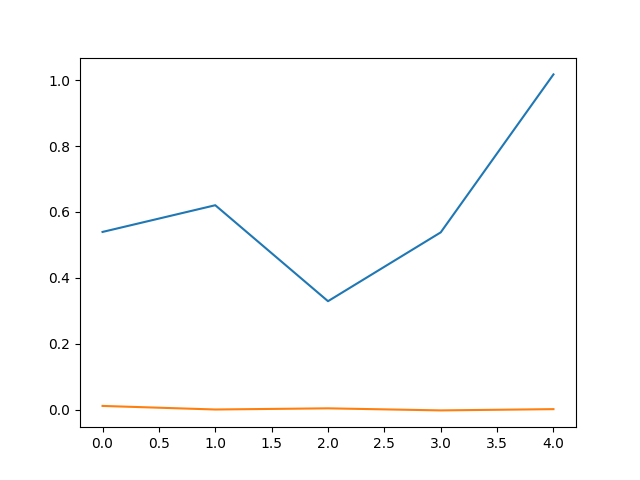

In [97]:
plt.figure()
plt.plot(ans.real)
plt.plot(ans.imag)

In [122]:
from craco import preprocess

In [127]:
input_data = np.ones((10, 20, 30), dtype=np.complex64)
output_data = np.empty_like(input_data)
Ai = np.zeros(1, dtype=np.complex64)
Qi = np.zeros(2, dtype=np.float32)
N = np.ones(1, dtype=np.int32)
bl_weights = np.ones(10, dtype=np.bool)
input_tf_weights = np.ones((20,30), dtype=np.bool)
fixed_freq_weights = np.ones(20, dtype=np.bool)
cal = np.ones((10, 20), dtype=np.complex64)

In [128]:
preprocess.fast_preprpocess_single_norm(input_data, bl_weights, fixed_freq_weights, input_tf_weights, output_data, 0, Ai, Qi, N, cal, 512, True)

In [129]:
output_data.mean()

/home/gup037/miniconda3/envs/craco/lib/python3.6/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/gup037/miniconda3/envs/craco/lib/python3.6/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


(nan+nanj)